<a href="https://colab.research.google.com/github/Dimisz/Portfolio/blob/main/Python/DeepLearning/TensorFlow/NLP/skim_lit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Replicating SkimLit

The purpose of the project is to build an NLP model to make reading medical abstracts easier.

The paper we are replicating is available here:


## Get the data

Let's download the dataset used for PubMed 200k RCT (the paper we're replicating).

We can download the dataset from the author's GitHub: https://github.com/Franck-Dernoncourt/pubmed-rct

In [1]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 0), reused 0 (delta 0), pack-reused 30
Unpacking objects: 100% (33/33), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [2]:
# Check what files are in the PubMed_20K dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [3]:
# Start our experiments using the 20k dataset with numbers replaced by '@' sign
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign"

In [4]:
# Check all of the filenames in the target directory
import os
filenames = [data_dir + "/" + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

## Preprocess data

Visualize our text data to get a better understanding of it.

To do this:
* Write a function to read the text files

In [5]:
# Create the function to read the lines of the document
def get_lines(filename):
  """
  Reads filename (a text filename) and returns the lines of text as a list.

  Args:
    filename: a string containing the target filepath.

  Returns:
    A list of strings with one string per line from the target filename.
  """
  with open(filename, "r") as f:
    return f.readlines()


In [6]:
train_lines = get_lines(data_dir + '/train.txt')
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [7]:
len(train_lines)

210040

In [8]:
# Create a funcction to preprocess our text to the fformat we need
def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence 
  number the target line is.
  """
  input_lines = get_lines(filename) # get all the lines from the file
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  #Loop throough each line in the target line
  for line in input_lines:
    if line.startswith('###'): # check if there is an ID line
      abstract_id = line
      abstract_lines = "" # reset the abstract string if the line is an ID line
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate llines

      # Iterate through each line in a single abstract and count them at the same line
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {}
        target_text_split = abstract_line.split("\t") #split target label ffrom text
        line_data["target"] = target_text_split[0]
        line_data["text"] = target_text_split[1].lower()
        line_data["line_number"] = abstract_line_number 
        line_data["total_lines"] = len(abstract_line_split)-1
        abstract_samples.append(line_data)
    
    else: #the line contains labelled sentence
      abstract_lines += line
    

  return abstract_samples


In [9]:
# Get data from file annd preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir+"/train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir+"/dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir+"/test.txt")
print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135
CPU times: user 581 ms, sys: 104 ms, total: 685 ms
Wall time: 691 ms


In [10]:
# Check the first abstract of our training data
train_samples[:10]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures include

In [11]:
import pandas as pd

train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [12]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [13]:
# Distribution of labels
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

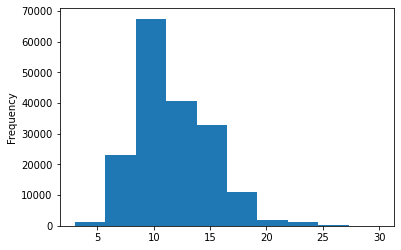

In [14]:
# Let's check length of different lines
train_df.total_lines.plot.hist()

### Get lists of sentences

In [15]:
# Convert abstract text lines into lists
train_sentences = train_df['text'].tolist()
val_sentences = val_df['text'].tolist()
test_sentences = test_df['text'].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [16]:
# View the first 10 lines of train sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numeric labels (for our ML model)

In [17]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False) # We want a non-sparse mmetrics
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_df['target'].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(test_df['target'].to_numpy().reshape(-1,1))
test_labels_one_hot

array([[1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.]])

## Label encode labels

In [18]:
# Extract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_encoder.transform(val_df['target'].to_numpy())
test_labels_encoded = label_encoder.transform(test_df['target'].to_numpy())


In [19]:
# Check what train labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [20]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Starting a series of modelling experiments

## Model 0: Getting a Baseline Model

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
                    ("tf-idf", TfidfVectorizer()),
                    ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences,
            y=train_labels_encoded)

Pipeline(memory=None,
         steps=[('tf-idf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [22]:
#Evaluate baseline model on validation dataset
model_0.score(X=val_sentences,
                 y=val_labels_encoded)

0.7218323844829869

In [23]:
# Make predictions using baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

### Download helper_functions.py

In [24]:
!wget https://raw.githubusercontent.com/Dimisz/Portfolio/main/Python/DeepLearning/TensorFlow/helper_functions.py

--2021-10-20 05:49:38--  https://raw.githubusercontent.com/Dimisz/Portfolio/main/Python/DeepLearning/TensorFlow/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-10-20 05:49:38 (73.1 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [25]:
from helper_functions import calculate_results

In [26]:
# Calculate baseline rresults
baseline_results = calculate_results(y_true=val_labels_encoded, 
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

## Prepare our data (text) for deep sequence models

Create vectorization and embedding layers before we start building models

In [27]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [28]:
#How long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_lens = np.mean(sent_lens)
avg_sent_lens

26.338269273494777

(array([4.2075e+04, 8.3771e+04, 3.6877e+04, 1.0945e+04, 3.9310e+03,
        1.4450e+03, 5.6000e+02, 2.2600e+02, 1.0100e+02, 4.5000e+01,
        2.0000e+01, 1.2000e+01, 9.0000e+00, 1.0000e+01, 6.0000e+00,
        2.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  1.  ,  15.75,  30.5 ,  45.25,  60.  ,  74.75,  89.5 , 104.25,
        119.  , 133.75, 148.5 , 163.25, 178.  , 192.75, 207.5 , 222.25,
        237.  , 251.75, 266.5 , 281.25, 296.  ]),
 <a list of 20 Patch objects>)

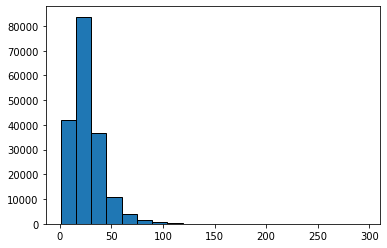

In [29]:
# What's the distribution look like?
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=20, edgecolor="black")

In [30]:
# How long of a sentence length covers 95% of example?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [31]:
# Max sequence len
max(sent_lens)

296

### Create text vectorizer layer

We want to make a layer which maps our texts from words to numbers

In [32]:
# How many words are in our vocabulary?
max_tokens = 68000


In [33]:
# Create text vectorizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens, #num words in vocab
                                    output_sequence_length=output_seq_len) #desired output length of vectorized seuences

In [34]:
# Adapt TextVectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [35]:
# Test out text vectorizer on some random sentences
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text:\n{len(target_sentence)}")
print(f"\nVectorized text:\n{text_vectorizer([target_sentence])}")
print(f"\nLength of vectorized text:\n{len(text_vectorizer([target_sentence])[0])}")

Text:
the metaplus study , a randomized , double-blind , multicenter trial , was conducted from february @ through april @ including a @-month follow-up period in @ intensive care units ( icus ) in the netherlands , germany , france , and belgium .

Length of text:
242

Vectorized text:
[[    2 52644    17     8    29   236   502    32    10   198    27  1886
    313  1441   251     8   178    94   173     5   642    77   937  5908
      5     2  2224  3098  5078     3  8980     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Length of vectorized text:
55


In [36]:
# How many words in our training vocabulary?
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")

# Print out the most common words
print(f"\nMost common words: {rct_20k_text_vocab[:10]}")

# Print out the least common words
print(f"\nLeast common words: {rct_20k_text_vocab[-10:]}")

Number of words in vocab: 64841

Most common words: ['', '[UNK]', 'the', 'and', 'of', 'in', 'to', 'with', 'a', 'were']

Least common words: ['aarm', 'aaqol', 'aaq', 'aanhui', 'aana', 'aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [37]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 68000,
 'name': 'text_vectorization',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True}

### Create custom text embedding

In [38]:
# Create token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab),
                               output_dim=128,
                               mask_zero=True,
                               name="token_embedding")

In [39]:
# Show an example embedding
print(f"Sentence before vectorization:\n {target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization: \n {vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")


Sentence before vectorization:
 the metaplus study , a randomized , double-blind , multicenter trial , was conducted from february @ through april @ including a @-month follow-up period in @ intensive care units ( icus ) in the netherlands , germany , france , and belgium .

Sentence after vectorization: 
 [[    2 52644    17     8    29   236   502    32    10   198    27  1886
    313  1441   251     8   178    94   173     5   642    77   937  5908
      5     2  2224  3098  5078     3  8980     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding:
[[[-0.04741837 -0.02296457 -0.0211184  ...  0.00855349  0.00842365
    0.03429865]
  [ 0.03979578 -0.00815583  0.0277863  ... -0.01176033  0.02003122
    0.01441712]
  [-0.00340016 -0.02528237 -0.03876944 ...  0.0350935  -0.01489475
    0.01481618]
  ...
  [ 0.03671317  0.02875577  0.0465809  ... -0.02946745  0.02171526
 

## Creating datasets (making sure our data loads as fast as possible)

For this purpose we are going to use `tf.data API`. Check the resources:
* https://www.tensorflow.org/guide/data_performance
* https://www.tensorflow.org/guide/data

In [40]:
# Turn our data into TF datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<TensorSliceDataset shapes: ((), (5,)), types: (tf.string, tf.float64)>

In [41]:
# Take the TensorSliceDataset's and turn them into prefetched datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

## Model 1: Conv1D with token embeddings

In [42]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) # vectorize text inputs
token_embeddings = token_embed(text_vectors) # Create embedding
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) #condense the output of our feature conv layer
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

# Commpile
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [43]:
model_1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 55)                0         
_________________________________________________________________
token_embedding (Embedding)  (None, 55, 128)           8299648   
_________________________________________________________________
conv1d (Conv1D)              (None, 55, 64)            41024     
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 5)                 325       
Total params: 8,340,997
Trainable params: 8,340,997
Non-trainable params: 0
___________________________________________________

In [44]:
# Fit the model
history_model_1 = model_1.fit(train_dataset, 
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 67s 117ms/step - loss: 0.9243 - accuracy: 0.6345 - val_loss: 0.6851 - val_accuracy: 0.7377
Epoch 2/3
562/562 [==============================] - 66s 117ms/step - loss: 0.6534 - accuracy: 0.7593 - val_loss: 0.6276 - val_accuracy: 0.7729
Epoch 3/3
562/562 [==============================] - 66s 117ms/step - loss: 0.6121 - accuracy: 0.7771 - val_loss: 0.5915 - val_accuracy: 0.7892


In [45]:
# Evaluate on whole validation dataset
model_1.evaluate(valid_dataset)

945/945 [==============================] - 5s 5ms/step - loss: 0.5928 - accuracy: 0.7880


[0.5928229689598083, 0.7880312204360962]

In [46]:
# Make predictions (probabilities for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape

(array([[4.2667419e-01, 1.7806241e-01, 8.1395589e-02, 2.8151989e-01,
         3.2348022e-02],
        [4.3223202e-01, 2.8500777e-01, 1.4116358e-02, 2.5791505e-01,
         1.0728816e-02],
        [1.4890577e-01, 7.3289364e-03, 1.8805884e-03, 8.4180593e-01,
         7.8796307e-05],
        ...,
        [7.0148885e-06, 6.9632370e-04, 7.5609836e-04, 4.6067544e-06,
         9.9853599e-01],
        [6.4258516e-02, 4.7980723e-01, 9.0267897e-02, 7.4907094e-02,
         2.9075921e-01],
        [1.6276516e-01, 7.2825235e-01, 5.2347157e-02, 2.6796756e-02,
         2.9838515e-02]], dtype=float32), (30212, 5))

In [47]:
# Convert pred_probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [48]:
# Calculate model_1 results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.80312458625711,
 'f1': 0.785803867741174,
 'precision': 0.7850132739025757,
 'recall': 0.7880312458625711}

In [49]:
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

## Model 2: Feature Extraction with pretrained token embeddings

Let's use pretrained word embeddings from TF hub, more speccifically, the universal sentence encoder:
https://tfhub.dev/google/universal-sentence-encoder/4

The paper originally used GloVe embeddings, but we are going to USE embeddings.

In [50]:
# Download pretrained Tendorflow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [51]:
# Test out the pretrained embedding on a random sentence

random_train_sentence = random.choice(train_sentences)
print(f"Random sentence:\n {random_train_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence}")
print(len(use_embedded_sentence[0]))

Random sentence:
 complete clinical clearance at @ weeks occurred in @ of @ patients ( @ % ; @ % ci , @ % -@ % ) with placebo ; @ of @ ( @ % ; @ % ci , @ % -@ % ) with low-dose treatment ; @ of @ ( @ % ; @ % ci , @ % -@ % ) with middle-dose treatment ; and @ of @ ( @ % ; @ % ci , @ % -@ % ) with high-dose treatment ( p = @ ) .
Sentence after embedding:
[[-7.05246553e-02 -3.78237083e-03 -1.10630663e-02 -7.00101331e-02
   2.64156107e-02 -5.44235148e-02  2.84702936e-03 -4.83582243e-02
   1.88419521e-02 -1.41030317e-02  8.93636346e-02 -3.74159962e-02
   1.35392416e-04 -1.74410809e-02  3.31442691e-02  4.94834967e-02
  -9.09868404e-02  3.35937808e-03 -1.45091992e-02  8.12578108e-03
   2.72983667e-02  8.65223352e-04  1.61661096e-02 -7.46826157e-02
  -3.66280340e-02 -1.79521795e-02 -1.01835709e-02 -5.96299767e-02
  -5.06080035e-03  6.96022436e-02  3.37797888e-02  9.10390615e-02
   4.10709716e-02  5.04260845e-02 -1.51710864e-02  3.66159938e-02
  -4.95247310e-03 -3.44425179e-02 -5.02809137e-02 -

### Building and fitting an NLP feature extraction model using pretrained embeddings TF Hub

In [52]:
# Define feature extraction model using TF Hub layer
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) # tokenize text and create embedding of each sequence (512 long vector)
x = layers.Dense(128, activation="relu")(pretrained_embedding)
# Note: could add more layers if you wanted to
outputs = layers.Dense(5, activation="softmax")(x) #create the output layer

model_2 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_2_USE_feature_extractor")


#Compile the model
model_2.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [53]:
model_2.summary()

Model: "model_2_USE_feature_extractor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None,)]                 0         
_________________________________________________________________
universal_sentence_encoder ( (None, 512)               256797824 
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 645       
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [54]:
# Fit model_2 to the data
history_model_2 = model_2.fit(train_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              validation_data=valid_dataset,
                              validation_steps=int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 10s 13ms/step - loss: 0.9149 - accuracy: 0.6525 - val_loss: 0.7964 - val_accuracy: 0.6912
Epoch 2/3
562/562 [==============================] - 7s 12ms/step - loss: 0.7685 - accuracy: 0.7020 - val_loss: 0.7545 - val_accuracy: 0.7064
Epoch 3/3
562/562 [==============================] - 7s 13ms/step - loss: 0.7509 - accuracy: 0.7124 - val_loss: 0.7370 - val_accuracy: 0.7138


In [55]:
# Evaluate on the whole validation dataset
model_2.evaluate(valid_dataset)

945/945 [==============================] - 10s 10ms/step - loss: 0.7390 - accuracy: 0.7154


[0.7390443086624146, 0.7153779864311218]

In [56]:
# Make predictions with feature extraction model
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

array([[4.3157941e-01, 3.6981836e-01, 2.1135577e-03, 1.8895350e-01,
        7.5352672e-03],
       [3.3313885e-01, 5.1777691e-01, 3.1186822e-03, 1.4313546e-01,
        2.8301328e-03],
       [2.3659046e-01, 1.5378806e-01, 2.1860240e-02, 5.4868239e-01,
        3.9078817e-02],
       ...,
       [1.5760531e-03, 5.3396034e-03, 4.6958081e-02, 8.3834445e-04,
        9.4528794e-01],
       [4.0139798e-03, 4.5777485e-02, 1.9541243e-01, 1.5952871e-03,
        7.5320077e-01],
       [1.9660288e-01, 2.6942074e-01, 4.6674147e-01, 6.7144679e-03,
        6.0520478e-02]], dtype=float32)

In [57]:
# Convert the prediction proobabilities found with feature extraction model to labels
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [58]:
# Calculate results from TF Hub 
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)

model_2_results

{'accuracy': 71.53779954984775,
 'f1': 0.7123094333178281,
 'precision': 0.7159589323092629,
 'recall': 0.7153779954984775}

In [59]:
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

In [60]:
model_1_results

{'accuracy': 78.80312458625711,
 'f1': 0.785803867741174,
 'precision': 0.7850132739025757,
 'recall': 0.7880312458625711}

## Model 3: Conv1D with character embeddings

### Create character level tokenizer

In [61]:
# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

In [62]:
split_chars(random_train_sentence)

'c o m p l e t e   c l i n i c a l   c l e a r a n c e   a t   @   w e e k s   o c c u r r e d   i n   @   o f   @   p a t i e n t s   (   @   %   ;   @   %   c i   ,   @   %   - @   %   )   w i t h   p l a c e b o   ;   @   o f   @   (   @   %   ;   @   %   c i   ,   @   %   - @   %   )   w i t h   l o w - d o s e   t r e a t m e n t   ;   @   o f   @   (   @   %   ;   @   %   c i   ,   @   %   - @   %   )   w i t h   m i d d l e - d o s e   t r e a t m e n t   ;   a n d   @   o f   @   (   @   %   ;   @   %   c i   ,   @   %   - @   %   )   w i t h   h i g h - d o s e   t r e a t m e n t   (   p   =   @   )   .'

In [63]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [64]:
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

In [65]:
# What's the average character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_lens = np.mean(char_lens)
mean_char_lens

149.3662574983337

(array([9.2691e+04, 7.6343e+04, 9.6890e+03, 1.0890e+03, 1.6700e+02,
        4.2000e+01, 1.3000e+01, 3.0000e+00, 2.0000e+00, 1.0000e+00]),
 array([1.0000e+00, 1.3950e+02, 2.7800e+02, 4.1650e+02, 5.5500e+02,
        6.9350e+02, 8.3200e+02, 9.7050e+02, 1.1090e+03, 1.2475e+03,
        1.3860e+03]),
 <a list of 10 Patch objects>)

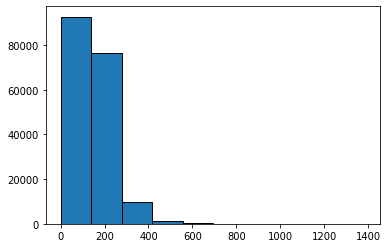

In [66]:
# Check the distribution of our sequences at a character level
import matplotlib.pyplot as plt
plt.hist(char_lens, edgecolor="black")

In [67]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [68]:
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [69]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 #add 2 for space and oov token
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    name="char_vectorizer")

In [70]:
# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

In [71]:
# Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [72]:
# Test our character vecctorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n {random_train_chars}")
print(f"Length of ranndom_train_chars: {len(random_train_chars)}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"Vectorized chars:\n {vectorized_chars}")
print(f"Length of vectorized_charrs: {len(vectorized_chars[0])}")

Charified text:
 v o l u m e   a s s u r e d   n i v   (   v a - n i v   )   m a y   i m p r o v e   c o m p l i a n c e   a n d   v e n t i l a t i o n   d u r i n g   s l e e p   b y   a u t o m a t i c a l l y   t i t r a t i n g   v e n t i l a t o r y   p r e s s u r e s   .
Length of ranndom_train_chars: 263
Vectorized chars:
 [[21  7 12 16 15  2  5  9  9 16  8  2 10  6  4 21 21  5  6  4 21 15  5 19
   4 15 14  8  7 21  2 11  7 15 14 12  4  5  6 11  2  5  6 10 21  2  6  3
   4 12  5  3  4  7  6 10 16  8  4  6 18  9 12  2  2 14 22 19  5 16  3  7
  15  5  3  4 11  5 12 12 19  3  4  3  8  5  3  4  6 18 21  2  6  3  4 12
   5  3  7  8 19 14  8  2  9  9 16  8  2  9  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

### Creating a character-level embedding

In [73]:
# Create a char embedding layer
char_embed = layers.Embedding(input_dim=len(char_vocab),
                              output_dim=25, # the size of char embedding in the paper
                              mask_zero=True,
                              name="char_embed"
                              )

In [74]:
# Test our embedding layer
print(f"Charified text:\n {random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding:\n {char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text:
 v o l u m e   a s s u r e d   n i v   (   v a - n i v   )   m a y   i m p r o v e   c o m p l i a n c e   a n d   v e n t i l a t i o n   d u r i n g   s l e e p   b y   a u t o m a t i c a l l y   t i t r a t i n g   v e n t i l a t o r y   p r e s s u r e s   .

Embedded chars (after vectorization and embedding:
 [[[ 0.002298   -0.03677506  0.04620253 ... -0.01581543  0.01528538
    0.03002002]
  [ 0.02617117 -0.01704415  0.00646598 ... -0.01615418 -0.00905555
   -0.00775477]
  [-0.0096227   0.02891829 -0.04424514 ...  0.03247029  0.03774695
   -0.03356748]
  ...
  [-0.04018631  0.02413961 -0.03413868 ...  0.01254966 -0.03780669
   -0.0159405 ]
  [-0.04018631  0.02413961 -0.03413868 ...  0.01254966 -0.03780669
   -0.0159405 ]
  [-0.04018631  0.02413961 -0.03413868 ...  0.01254966 -0.03780669
   -0.0159405 ]]]

Character embedding shape: (1, 290, 25)


### Building a Conv1D to fit on character embeddinng

In [75]:
# Make Conv1D on chars only
inputs = layers.Input(shape=(1,),
                      dtype=tf.string)
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_3_conv1d_char_embeddings")
# Compile 
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [76]:
model_3.summary()

Model: "model_3_conv1d_char_embeddings"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
char_vectorizer (TextVectori (None, 290)               0         
_________________________________________________________________
char_embed (Embedding)       (None, 290, 25)           700       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 290, 64)           8064      
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 325       
Total params: 9,089
Trainable params: 9,089
Non-trainable params: 0
__________________________________

In [77]:
# Create char level datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)


train_char_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

In [78]:
# Fit the model onn chars only
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1*len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1*len(val_char_dataset)))


Epoch 1/3
562/562 [==============================] - 18s 31ms/step - loss: 1.2551 - accuracy: 0.4835 - val_loss: 1.0423 - val_accuracy: 0.5735
Epoch 2/3
562/562 [==============================] - 17s 30ms/step - loss: 1.0131 - accuracy: 0.5930 - val_loss: 0.9515 - val_accuracy: 0.6210
Epoch 3/3
562/562 [==============================] - 17s 30ms/step - loss: 0.9359 - accuracy: 0.6313 - val_loss: 0.8886 - val_accuracy: 0.6516


In [79]:
# Make predictions with character model only
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

array([[0.1811185 , 0.34367874, 0.20550811, 0.24278311, 0.02691152],
       [0.13021652, 0.4865239 , 0.03174498, 0.25202656, 0.09948792],
       [0.14807434, 0.20318691, 0.3347782 , 0.20552705, 0.10843349],
       ...,
       [0.01164077, 0.03527961, 0.16079055, 0.03219201, 0.760097  ],
       [0.02307026, 0.04571687, 0.5383894 , 0.04549888, 0.3473246 ],
       [0.5027821 , 0.31758258, 0.13074535, 0.04525878, 0.00363117]],
      dtype=float32)

In [80]:
# Convert prediction probabilities to class values
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 2, ..., 4, 2, 0])>

In [81]:
# Calculate results for Conv1D model chars only
model_3_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 64.80206540447504,
 'f1': 0.6361477939725904,
 'precision': 0.6422621410579682,
 'recall': 0.6480206540447504}

In [82]:
model_3_results

{'accuracy': 64.80206540447504,
 'f1': 0.6361477939725904,
 'precision': 0.6422621410579682,
 'recall': 0.6480206540447504}

## Model 4: Combining pretrained token embeddings + character embeddings

1. Create a token-level embedding model (similar to `model_1`)
2. Create a character-level model (similar to `model_3` with a slight modification)
3. Combine 1 & 2 with a concatenate layer (`layers.Concatenate`)
4. Build a series of output layers on top of 3
5. Construct a model which takes token and character-level sequence as input and produces sequence label probabilities as output

### 1. Setup token inputs/model

In [83]:
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs, 
                             outputs=token_output)


### 2. Create a character-level model

In [84]:
#Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

### 3. Combine 1 & 2 with a `Concatenate layer`

In [85]:
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                  char_model.output])

### 4. Build a series of output layers on top of hybrid model (adding Dropout)

In [86]:
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation="relu")(combined_dropout)

final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

### 5. Construct a model that takes character and token level sequences as input


In [87]:
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")

In [88]:
# Get a summary 
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
token_input (InputLayer)        [(None,)]            0                                            
__________________________________________________________________________________________________
char_vectorizer (TextVectorizat (None, 290)          0           char_input[0][0]                 
__________________________________________________________________________________________________
universal_sentence_encoder (Ker (None, 512)          256797824   token_input[0][0]                
__________________________________________________________________

### Plot hybrid token and character model


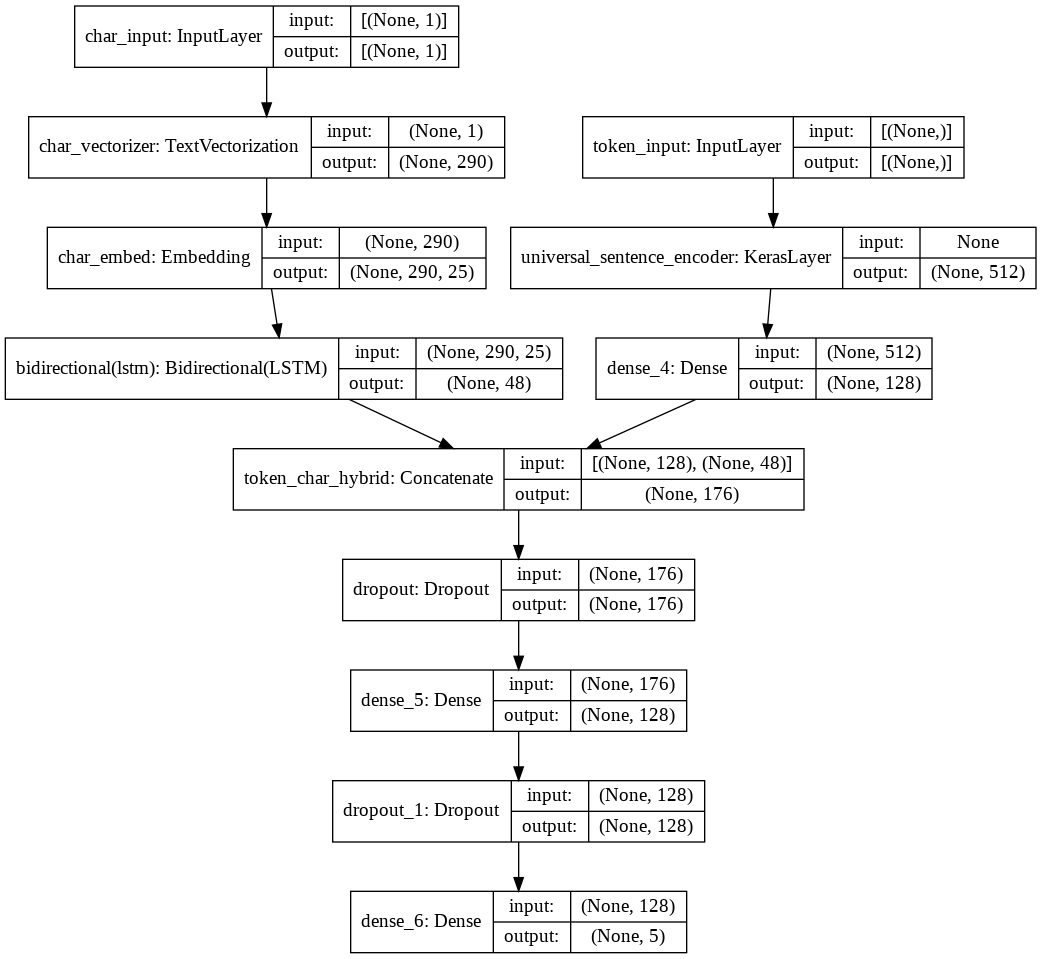

In [89]:
import tensorflow as tf
#from tensorflow import keras

from tensorflow.keras.utils import plot_model
plot_model(model_4, show_shapes=True)

In [90]:
# Compile token char model
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

### Combining token and character data into a tf.data Dataset

In [91]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_char_token_labels = tf.data.Dataset.from_tensor_slices((train_labels_one_hot))
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels))

In [92]:
#Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [93]:
# Repeat the above for validation dataset

val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices((val_labels_one_hot))
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))

#Prefetch and batch train data
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [94]:
# Check out our training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>)

### Fitting a model on token and character-level sequences

In [95]:
# Fit the model on tokens and chars
history_model_4 = model_4.fit(train_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1*len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 216s 368ms/step - loss: 0.9783 - accuracy: 0.6109 - val_loss: 0.7912 - val_accuracy: 0.6955
Epoch 2/3
562/562 [==============================] - 191s 340ms/step - loss: 0.8072 - accuracy: 0.6857 - val_loss: 0.7226 - val_accuracy: 0.7261
Epoch 3/3
562/562 [==============================] - 192s 341ms/step - loss: 0.7762 - accuracy: 0.7040 - val_loss: 0.6908 - val_accuracy: 0.7394


In [96]:
# Evaluate on the whole validation dataset
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 67s 71ms/step - loss: 0.6954 - accuracy: 0.7350


[0.6953659057617188, 0.7350059747695923]

In [97]:
# Make predictions using the token-character model hybrid
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

array([[4.3761742e-01, 3.2724199e-01, 4.2508394e-03, 2.2698209e-01,
        3.9076461e-03],
       [3.6885029e-01, 4.8594478e-01, 2.2713821e-03, 1.4190245e-01,
        1.0311166e-03],
       [3.0409485e-01, 1.6307275e-01, 3.8249921e-02, 4.6688968e-01,
        2.7692804e-02],
       ...,
       [5.0930987e-04, 7.9180980e-03, 4.6841029e-02, 2.4240727e-04,
        9.4448918e-01],
       [9.6321665e-03, 5.4762322e-02, 2.5817561e-01, 3.7067586e-03,
        6.7372316e-01],
       [2.7016166e-01, 3.5455307e-01, 2.7979797e-01, 3.4686375e-02,
        6.0800958e-02]], dtype=float32)

In [98]:
# Format pred probs into pred labels
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1])>

In [99]:
# Get results of token char hybrid model
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)

In [100]:
model_4_results

{'accuracy': 73.50059578975242,
 'f1': 0.7318192079889386,
 'precision': 0.7347798000003282,
 'recall': 0.7350059578975242}

## Model 5: Transfer Learning with pretrained token embeddings + character embeddings

### Create positional embeddings

In [101]:
# How many different line numbers are there?
train_df['line_number'].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

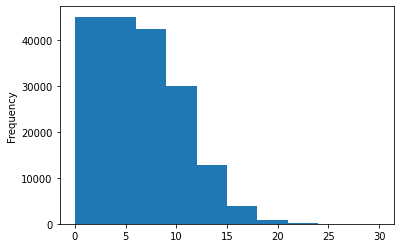

In [102]:
# Check the distribution of 'line_number' column
train_df.line_number.plot.hist()

In [103]:
# Use TF to create one-hot-encoded tensors of the 'line_number' column
train_line_numbers_one_hot = tf.one_hot(train_df['line_number'].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df['line_number'].to_numpy(), depth=15)
test_line_number_one_hot = tf.one_hot(test_df['line_number'].to_numpy(), depth=15)
train_line_numbers_one_hot[:10], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>, TensorShape([180040, 15]))

### Encode 'total_lines' feature


In [104]:
# How many numbers of lines are there?
train_df['total_lines'].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

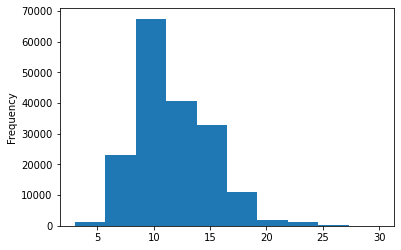

In [105]:
train_df['total_lines'].plot.hist()

In [106]:
# Check the coverage of a 'total_lines' value of 20
np.percentile(train_df.total_lines, 98)

20.0

In [107]:
# Use TF to create one_hot_encoded tensors of our 'total_lines' feature
train_total_lines_one_hot = tf.one_hot(train_df['total_lines'].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df['total_lines'].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df['total_lines'].to_numpy(), depth=20)

train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 20]), <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.

### Building a tribrid embedding model

1. Create a token-level model
2. Create a character-level model
3. Create a model for the 'line_number' feature
4. Create a model for the 'total_lines' feature
5. Combine the outputs of 1 & 2 using tf.keras.layers.Concatenate
6. Combine the outputs of 3,4,5 using tf.keras.layers.Concatenate
7. Create an output layer to accept the tribrid embedding and output label probabilities
8. Combine the inputs of 1, 2, 3 and 4, and outputs of 7 into a tf.keras.Model

#### 1.Token inputs

In [108]:
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                              outputs=token_outputs)

#### 2.Character-level model




In [109]:
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm
                            )

#### 3.Model for 'line_number' feature

In [110]:
line_number_inputs = layers.Input(shape=(15,), dtype=tf.float32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                    outputs=x)

#### 4. Model for 'total_lines' feature

In [111]:
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.float32, name="total_lines_inputs")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs=total_lines_inputs,
                                   outputs=y)

#### 5. Combine token and char embeddings into a hybrid embedding

In [112]:
combined_embeddings = layers.Concatenate(name="char_token_hybrid_embedding")([token_model.output,
                                                                              char_model.output])
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

#### 6. Combine positional embeddings with combined token and char embeddings


In [113]:
tribrid_embeddings = layers.Concatenate(name="tribrid_embedding")([line_number_model.output,
                                                                   total_lines_model.output,
                                                                   z])

#### 7.Create output layer

In [114]:
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(tribrid_embeddings)

#### 8. Put everything together

In [115]:
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_lines_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer, 
                         name="model_5_tribrid_embedding_model")

In [116]:
model_5.summary()

Model: "model_5_tribrid_embedding_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_inputs (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
token_inputs (InputLayer)       [(None,)]            0                                            
__________________________________________________________________________________________________
char_vectorizer (TextVectorizat (None, 290)          0           char_inputs[0][0]                
__________________________________________________________________________________________________
universal_sentence_encoder (Ker (None, 512)          256797824   token_inputs[0][0]               
____________________________________________________________________

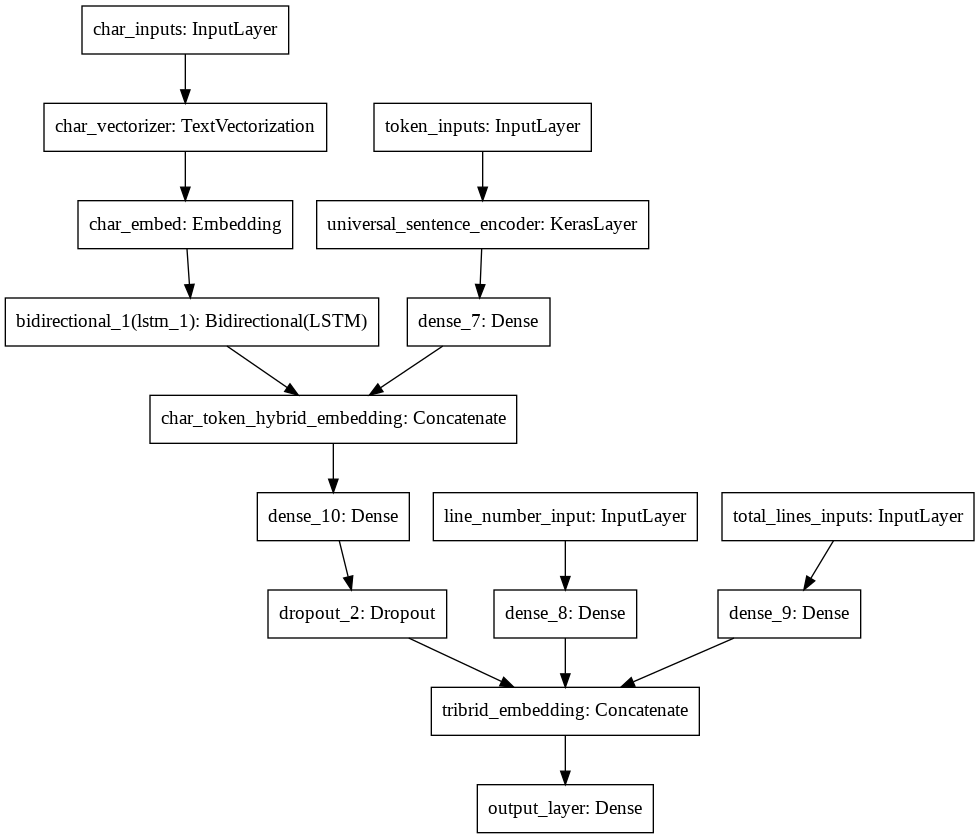

In [117]:
# Plot model_5
from tensorflow.keras.utils import plot_model
plot_model(model_5)

In [118]:
# Compile model_5
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

### Create tribrid embedding datasets using `tf.data`

In [119]:
# Create training and validation datasets with all four kinds of input data
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                    train_total_lines_one_hot,
                                                    train_sentences,
                                                    train_chars))
train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data,
                                                train_char_token_pos_labels))

train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

#Do the same for validation dataset
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                    val_total_lines_one_hot,
                                                    val_sentences,
                                                    val_chars))
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data,
                                                val_char_token_pos_labels))

val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)



In [120]:
# Check input shapes
train_char_token_pos_dataset, val_char_token_pos_dataset

(<PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>)

In [121]:
# Fitting the model
history_model_5 = model_5.fit(train_char_token_pos_dataset,
                              epochs=3,
                              steps_per_epoch=len(train_char_token_pos_dataset),
                              validation_data=val_char_token_pos_dataset,
                              validation_steps=len(val_char_token_pos_dataset))

Epoch 1/3
5627/5627 [==============================] - 1954s 346ms/step - loss: 0.9525 - accuracy: 0.8237 - val_loss: 0.9068 - val_accuracy: 0.8492
Epoch 2/3
5627/5627 [==============================] - 1861s 331ms/step - loss: 0.9081 - accuracy: 0.8543 - val_loss: 0.8978 - val_accuracy: 0.8554
Epoch 3/3
5627/5627 [==============================] - 1857s 330ms/step - loss: 0.8954 - accuracy: 0.8633 - val_loss: 0.8955 - val_accuracy: 0.8555


In [122]:
# Evaluating model_5
model_5.evaluate(val_char_token_pos_dataset)

945/945 [==============================] - 65s 69ms/step - loss: 0.8955 - accuracy: 0.8555


[0.8955192565917969, 0.8554878830909729]

In [123]:
# Making predictions
model_5_pred_probs = model_5.predict(val_char_token_pos_dataset)
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 85.54878856083675,
 'f1': 0.8528824746018624,
 'precision': 0.8561205689559556,
 'recall': 0.8554878856083675}

## Compare model results

In [124]:
# Combine model results into a dataframe

all_model_results = pd.DataFrame({"model_0_baseline": baseline_results,
                                 "model_1_custom_token_embedding": model_1_results,
                                  "model_2_pretrained_token_embedding":model_2_results,
                                  "model_3_char_embedding": model_3_results,
                                  "model_4_hybrid_char_token_embedding":model_4_results,
                                  "model_5_pos_char_token_embedding":model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
model_0_baseline,72.183238,0.718647,0.721832,0.698925
model_1_custom_token_embedding,78.803125,0.785013,0.788031,0.785804
model_2_pretrained_token_embedding,71.537800,0.715959,0.715378,0.712309
model_3_char_embedding,64.802065,0.642262,0.648021,0.636148
model_4_hybrid_char_token_embedding,73.500596,0.734780,0.735006,0.731819
model_5_pos_char_token_embedding,85.548789,0.856121,0.855488,0.852882


In [125]:
# Reduce the accuracy to same scale as other metrics
all_model_results['accuracy'] = all_model_results['accuracy']/100

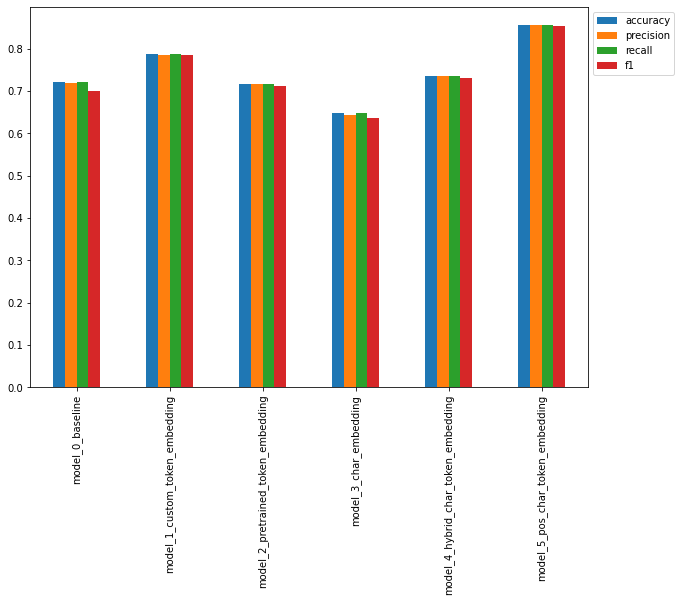

In [126]:
# Plot and compare all model results
all_model_results.plot(kind="bar", figsize=(10,7)).legend(bbox_to_anchor=(1.0,1.0));

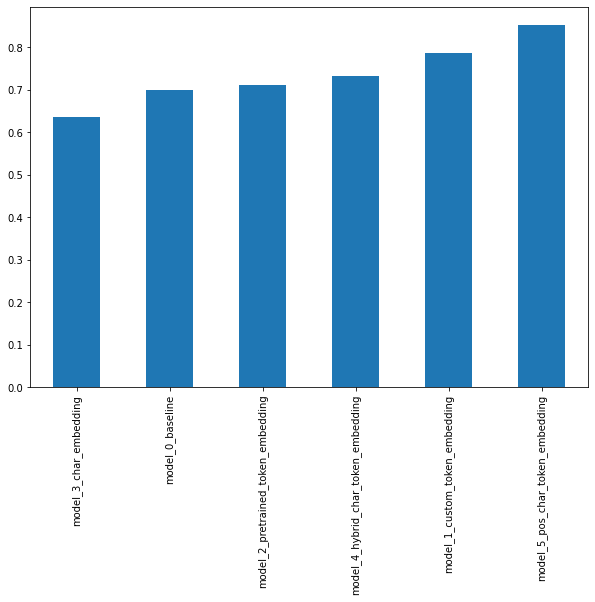

In [127]:
# Sort the models' results by f1-score
all_model_results.sort_values("f1", ascending=True)['f1'].plot(kind="bar", figsize=(10,7))

## Save and Load the Model

In [128]:
model_5.summary()

Model: "model_5_tribrid_embedding_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_inputs (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
token_inputs (InputLayer)       [(None,)]            0                                            
__________________________________________________________________________________________________
char_vectorizer (TextVectorizat (None, 290)          0           char_inputs[0][0]                
__________________________________________________________________________________________________
universal_sentence_encoder (Ker (None, 512)          256797824   token_inputs[0][0]               
____________________________________________________________________

In [2]:
# Save the best-performing model
#tf.keras.models.save_model(model_5, filepath="/content")
#model_5.save("model_5.h5")